Importing libraries

In [33]:
import pandas as pd
import numpy as np
from scipy.io import mmread
from scipy import stats
from scipy import sparse
import anndata as ad
import scanpy as sc
import math
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from scipy.signal import find_peaks
import statsmodels.api as sm
import scrublet as scr
import warnings
from scipy import interpolate

<H1>Loading Data</H1>

Getting the python annotated object

In [19]:
ann_object = sc.read(filename='dades/48h/ann_object.h5ad')
ann_object

AnnData object with n_obs × n_vars = 7677 × 32285
    varm: 'gene_cientific_name'

<H1>Quality Control</H1>

Getting Mitocondrial genes

In [20]:
ann_object.var["mithocondrial"] = ann_object.var_names.str.startswith("mt-")
ann_object.var_names[ann_object.var["mithocondrial"]]

Index(['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3',
       'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb'],
      dtype='object')

In [21]:
sc.pp.calculate_qc_metrics(ann_object, qc_vars=['mithocondrial'], inplace=True)
ann_object

AnnData object with n_obs × n_vars = 7677 × 32285
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mithocondrial', 'log1p_total_counts_mithocondrial', 'pct_counts_mithocondrial'
    var: 'mithocondrial', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    varm: 'gene_cientific_name'

* **total_genes_by_counts**. Number of genes with positive counts in a cell. (total gene count having True ERCC)
* **total_counts**. Total number of counts for a cell.
* **pct_counts_in_top_50_genes**. Cumulative percentage of counts for 50 most expressed genes in a cell.
* **total_counts_ercc**. Total number of counts for variabes in qc_vars.
* **pct_counts_ercc**. Proportion of total counts for a cell which are ercc.
* **total_counts**. Sum of counts for a gene.
* **n_genes_by_counts**. The number of genes with at least 1 count in a cell. Calculated for all cells.
* **mean_counts**. Mean expression over all cells.
* **n_cells_by_counts**. Number of cells this expression is measured in.
* **pct_dropout_by_counts**. Percentage of cells this feature does not appear in.
* **pct_counts_mithocondrial**. Percentage of mithocondrial genes in a cell. Calculated for all cells.

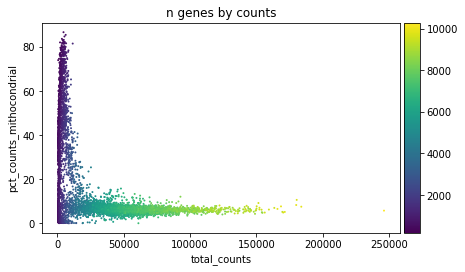

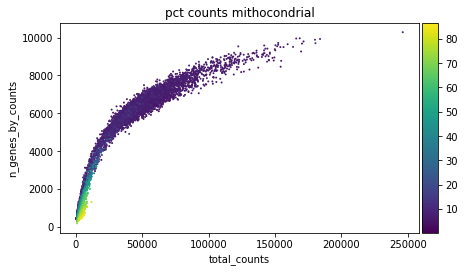

In [22]:
# Visualizing the dataset.
sc.pl.scatter(ann_object, x='total_counts', y='pct_counts_mithocondrial', color='n_genes_by_counts')
sc.pl.scatter(ann_object, x='total_counts', y='n_genes_by_counts', color='pct_counts_mithocondrial')

It seems that there are outliers on the scatter plots, probably caused by dying cells and by doublets.

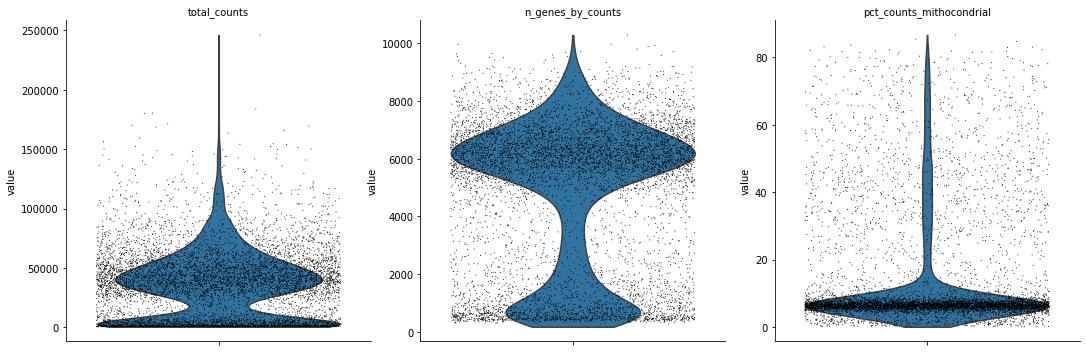

In [23]:
sc.pl.violin(
    ann_object,
    ["total_counts", "n_genes_by_counts","pct_counts_mithocondrial"],
    jitter=0.4,
    multi_panel=True
)

<H2>Number of counts per barcode (count depth)</H2>

*Counts of number of genes for the total number of genes by cell*

In [24]:
total_cell_counts = ann_object.obs["total_counts"].values

In [25]:
def fd_optimal_bins(data: np.array) -> int:
    """ The Freedman-Diaconis rule for optimal bin selection
    Parameters: 
        data (np.array) - a one-dimensional array with data
    Returns:
        nbins (int) - number of bins
    """
    assert data.ndim == 1
    n = data.size
    
    p25, p75 = np.percentile(data, [25, 75]) #selects de 50% of the data

    width = 2. * (p75 - p25)/n**(1./3)
    nbins = math.ceil((data.max() - data.min()) / width)
    nbins = max(1, nbins)
    
    return nbins

In [27]:
total_cell_nbins = fd_optimal_bins(total_cell_counts)
print(f"Optimal number of bins: {total_cell_nbins}")

Optimal number of bins: 55


In [28]:
labels_total_cell_counts = {'xlabel': 'Total counts', 'ylabel': 'N barcodes'}

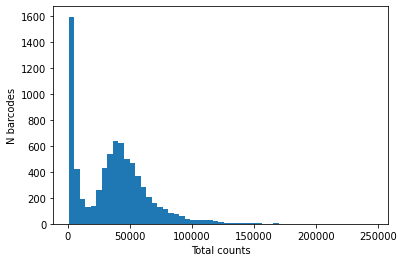

In [29]:
plt.figure()
plt.hist(total_cell_counts, bins=total_cell_nbins)
plt.xlabel(labels_total_cell_counts['xlabel'])
plt.ylabel(labels_total_cell_counts['ylabel'])
plt.show()

The y-axis correspond to number of barcodes and x-axis correponds to the total counts of all the genes in the cell.
The 0 or close to 0 values can correspond to dying cells: non cell or died cell. (There are no counts of any gene in a cell).
The higher outlier values could correspond to doublet cells.(There exists too much representation of genes in a cell)

<H3>Checking the died, empty, broken or stressed cells</H3>

<H4>Local minimums of kernel density functions with estimators of the optimal bandwidth</H4>

The bandwith defines smoothness of the density plot. (https://aakinshin.net/posts/kde-bw/).
For their election, we define a Cross-Validated function for choosing the optimal bandwith for the kernel density function on the total counts of cells. This function recieves a grid of possible bandwith values starting from a downstream of 2 factors of the standard deviation of the counts and ending with the standard deviation.

In [30]:
def choose_kernel_density_function_by_optimal_bandwith(qc_metrics):
    """
    qc_metrics: Quality control metric
    """
    # Determine the search space for the bandwidth parameter
    params = {"bandwidth": np.linspace(np.std(qc_metrics)/100, np.std(qc_metrics), 10)} #starting from a downstream of 2 factors of std of qc_metrics
    # Create a grid search object to find the optimal bandwidth
    grid = GridSearchCV(KernelDensity(kernel='gaussian'), params).fit(qc_metrics.reshape(-1,1))
    # Return the best-fit KDE object
    kde = grid.best_estimator_
    return kde

In [31]:
def local_minimum_of_kernel_density_function(qc_metrics, bins, kde):
    """
    qc_metrics: Array of quality control metrics.
    bins: Number of bins for the density estimation.
    kde: Kernel density function object.
    """
    # Generate evenly spaced points within the data range
    x_grid = np.linspace(0, max(qc_metrics), bins)
    # Evaluate the KDE at the grid points (ensure negative values are 0)
    kde_densities = np.exp(kde.score_samples(x_grid.reshape(-1, 1)))
    kde_densities[kde_densities < 0] = 0
    # Find potential local minima using SciPy's find_peaks with prominence threshold
    peaks, _ = find_peaks(-kde_densities)
    # Plot
    plt.figure()
    plt.plot(x_grid, kde_densities, label='KDE')
    plt.axhline(y=0, color='gray', linestyle='--', label='Zero level')
    plt.scatter(x_grid[peaks], kde_densities[peaks], marker='x', c='red', label='Local minimums')
    plt.xlabel('Quality Control Metric')
    plt.ylabel('Density of the KDE')
    plt.legend()
    plt.show()

    # Return the value of the first local minimum
    return x_grid[peaks[0]]

In [34]:
kde_total_cell_counts = choose_kernel_density_function_by_optimal_bandwith(total_cell_counts)
print(f"Bandwidth choosed for KDE of total cell counts: {kde_total_cell_counts}")

Bandwidth choosed for KDE of total cell counts: KernelDensity(bandwidth=3397.766484375)


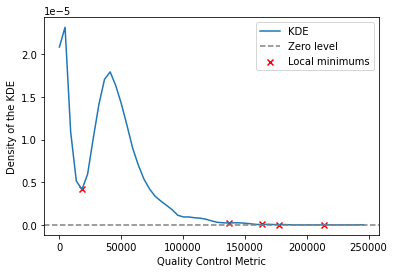

In [35]:
threshold_total_cell_counts_dying_cells = local_minimum_of_kernel_density_function(total_cell_counts, total_cell_nbins, kde_total_cell_counts)

We choose the first local minimum of the kernel density function as a limit that indicates the dying cells

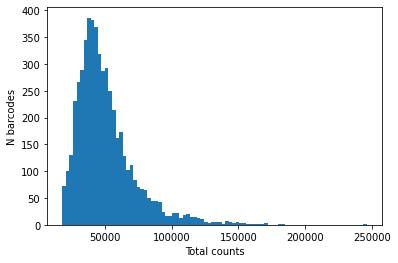

In [36]:
total_cell_counts_nodying = np.array([x for x in total_cell_counts if x>threshold_total_cell_counts_dying_cells])
total_cell_nodying_nbins = fd_optimal_bins(total_cell_counts_nodying)
plt.figure()
plt.hist(total_cell_counts_nodying, bins=total_cell_nodying_nbins)
plt.xlabel(labels_total_cell_counts['xlabel'])
plt.ylabel(labels_total_cell_counts['ylabel'])
plt.show()

Above we see the total cell counts data without possible dying cells

<H3>Checking the fat tail looking for doublet using robust linear models analysis of observed transcriptomes</H3>

Identifying doublets is crucial as they can lead to misclassifications or distortions in downstream analysis steps.

In [37]:
def fat_tail_for_doublets(qc_metrics_nodying, bins_nodying, labels, threshold_left=None, qc_metrics_complete=None, bins_complete=None):
    """
    qc_metrics_nodying: Quality control metric without dying cells.
    bins_nodying: Number of bins for the no-dying cells metric.
    labels: Dictionary containing labels for x and y axes.
    threshold_left(optional): Threshold for dying cells.
    qc_metrics_complete(optional): Quality control metric with all values.
    bins_complete(optional): Number of bins for the complete metric.
    """
    # Calculate robust statistics using Huber's M-estimator
    hb_mean = sm.robust.scale.huber(qc_metrics_nodying)[0] #mean
    hb_std = sm.robust.scale.huber(qc_metrics_nodying)[1] #std
    # Define threshold for right-side fat tail based on Huber's M-estimator
    huber_right_fat_tail = hb_mean+3*(hb_std)
    # Filter no-dying cells based on the threshold
    qc_metrics_huber = [x for x in qc_metrics_nodying if x<huber_right_fat_tail]
    # Handle complete data (if provided)
    if threshold_left is None:
        qc_metrics_complete = qc_metrics_nodying
        bins_complete = bins_nodying
    # Generate histogram
    plt.figure()
    plt.hist(qc_metrics_complete, bins=bins_complete)
    plt.xlabel(labels['xlabel'])
    plt.ylabel(labels['ylabel'])
    # Add threshold lines (if applicable)
    if threshold_left is not None: plt.axvline(threshold_left, color="red", label="Dying Cell Threshold")
    plt.axvline(huber_right_fat_tail, color="grey", label="Fat tail based on Huber's M-estimator Threshold")
    plt.legend()
    plt.show()
    
    return huber_right_fat_tail, hb_mean, hb_std

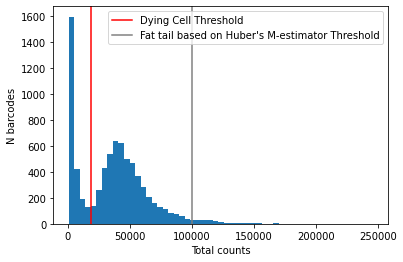

In [38]:
threshold_total_cell_counts_doublet_cells, hb_mean_total_cell_counts, hb_std_total_cell_counts = fat_tail_for_doublets(total_cell_counts_nodying, total_cell_nodying_nbins, labels_total_cell_counts, threshold_total_cell_counts_dying_cells, total_cell_counts, total_cell_nbins)

In [39]:
print(f"Statistics BEFORE fat-tail based on Huber's M-estimator: MEAN {np.mean(total_cell_counts_nodying)}, STD {np.std(total_cell_counts_nodying)}")
print(f"Statistics AFTER fat-tail based on Huber's M-estimator: MEAN {hb_mean_total_cell_counts}, STD {hb_std_total_cell_counts}")
print(f"Fat tail based on Huber's M-estimator THRESHOLD: {hb_mean_total_cell_counts+3*hb_std_total_cell_counts}")

Statistics BEFORE fat-tail based on Huber's M-estimator: MEAN 50690.6953125, STD 22197.376953125
Statistics AFTER fat-tail based on Huber's M-estimator: MEAN 47988.190272185275, STD 17388.516851588218
Fat tail based on Huber's M-estimator THRESHOLD: 100153.74082694993


<H2> Number of genes expressed by genes </H2>

*Number of genes with representation (at least one count) by cell*

In [40]:
n_genes_by_counts = ann_object.obs["n_genes_by_counts"].values
n_genes_by_counts_nbins = fd_optimal_bins(n_genes_by_counts)
print(f"Optimal number of bins: {n_genes_by_counts_nbins}")

Optimal number of bins: 24


In [41]:
labels_n_genes_by_counts = {'xlabel': 'Number of genes with representation (at least one count)', 'ylabel': 'N barcodes'}

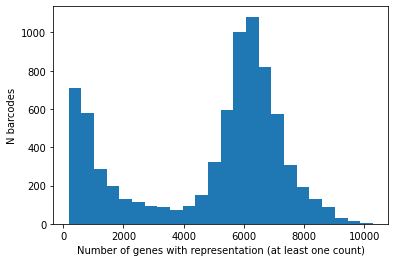

In [42]:
plt.figure()
plt.hist(n_genes_by_counts, bins=n_genes_by_counts_nbins)
plt.xlabel(labels_n_genes_by_counts['xlabel'])
plt.ylabel(labels_n_genes_by_counts['ylabel'])
plt.show()

The y-axis correspond to number of barcodes and x-axis correponds to the number of genes with representation (at least one count) in the cell.
The 0 or close to 0 values can correspond to dying cells: non cell or died cell. (There are no representation of any gene in a cell).
The higher outlier values could correspond to doublet cells. (https://www.statsmodels.org/stable/rlm.html) (There exists too much representation of genes in a cell)

<H3>Checking the dying cells</H3>

In [43]:
kde_n_genes_by_counts = choose_kernel_density_function_by_optimal_bandwith(n_genes_by_counts)
print(f"Bandwidth choosed for KDE of total cell counts: {kde_n_genes_by_counts}")

Bandwidth choosed for KDE of total cell counts: KernelDensity(bandwidth=25.213011283424645)


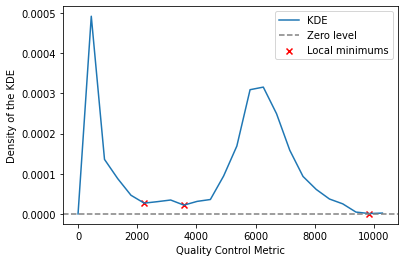

In [44]:
threshold_n_genes_by_counts_dying_cells = local_minimum_of_kernel_density_function(n_genes_by_counts, n_genes_by_counts_nbins, kde_n_genes_by_counts)

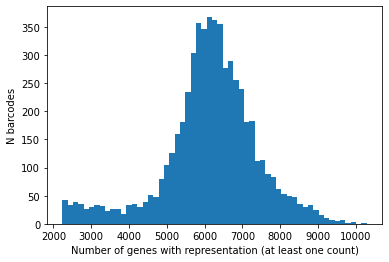

In [45]:
n_genes_by_counts_nodying = np.array([x for x in n_genes_by_counts if x>threshold_n_genes_by_counts_dying_cells])
n_genes_by_counts_nodying_nbins = fd_optimal_bins(n_genes_by_counts_nodying)
plt.figure()
plt.hist(n_genes_by_counts_nodying, bins=n_genes_by_counts_nodying_nbins)
plt.xlabel(labels_n_genes_by_counts['xlabel'])
plt.ylabel(labels_n_genes_by_counts['ylabel'])
plt.show()

<H3>Checking the fat tail looking for doublet using robust linear models analysis of observed transcriptomes</H3>

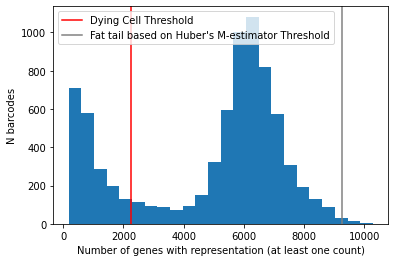

In [46]:
threshold_n_genes_by_counts_doublet_cells, hb_mean_n_genes_by_counts, hb_std_n_genes_by_counts = fat_tail_for_doublets(n_genes_by_counts_nodying, n_genes_by_counts_nodying_nbins, labels_n_genes_by_counts, threshold_n_genes_by_counts_dying_cells, n_genes_by_counts, n_genes_by_counts_nbins)

In [47]:
print(f"Statistics BEFORE fat-tail based on Huber's M-estimator: MEAN {np.mean(n_genes_by_counts_nodying)}, STD {np.std(n_genes_by_counts_nodying)}")
print(f"Statistics AFTER fat-tail based on Huber's M-estimator: MEAN {hb_mean_n_genes_by_counts}, STD {hb_std_n_genes_by_counts}")
print(f"Fat tail based on Huber's M-estimator THRESHOLD: {hb_mean_n_genes_by_counts+3*hb_std_n_genes_by_counts}")

Statistics BEFORE fat-tail based on Huber's M-estimator: MEAN 6142.68326417704, STD 1256.451025061574
Statistics AFTER fat-tail based on Huber's M-estimator: MEAN 6210.791785971064, STD 1020.6487178195375
Fat tail based on Huber's M-estimator THRESHOLD: 9272.737939429677


<H2> Proportion of mithocondrial per cell </H2>

*Proportion of mithocondrial genes of all the genes represented in a cell*

In [48]:
pct_counts_mithocondrial = ann_object.obs["pct_counts_mithocondrial"].values
pct_counts_mithocondrial_nbins = fd_optimal_bins(pct_counts_mithocondrial)
print(f"Optimal number of bins: {pct_counts_mithocondrial_nbins}")

Optimal number of bins: 306


In [49]:
labels_pct_counts_mithocondrial = {'xlabel': 'Proportion of mithocondrial genes', 'ylabel': 'N barcodes'}

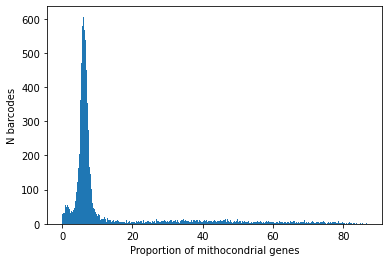

In [50]:
plt.figure()
plt.hist(pct_counts_mithocondrial, bins=pct_counts_mithocondrial_nbins)
plt.xlabel(labels_pct_counts_mithocondrial['xlabel'])
plt.ylabel(labels_pct_counts_mithocondrial['ylabel'])
plt.show()

The y-axis correspond to number of barcodes and x-axis correponds to the proportion of mithocondrial genes by cell.
The 0 or close to 0 values can correspond to cells of just nucleous (no proportion of mithocondrial part).
The higher outlier values could correspond to cells without nucleous (excesive proportion of mithocondrial part).

<H3>Checking the dying cells</H3>

In [51]:
kde_pct_counts_mithocondrial = choose_kernel_density_function_by_optimal_bandwith(pct_counts_mithocondrial)
print(f"Bandwidth choosed for KDE of total cell counts: {kde_pct_counts_mithocondrial}")

Bandwidth choosed for KDE of total cell counts: KernelDensity(bandwidth=0.16929819107055663)


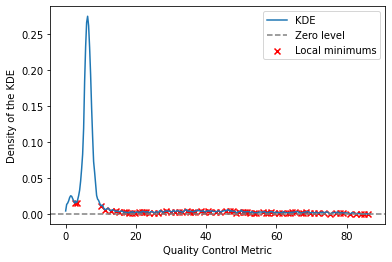

In [52]:
threshold_pct_counts_mithocondrial_dying_cells = local_minimum_of_kernel_density_function(pct_counts_mithocondrial, pct_counts_mithocondrial_nbins, kde_pct_counts_mithocondrial)

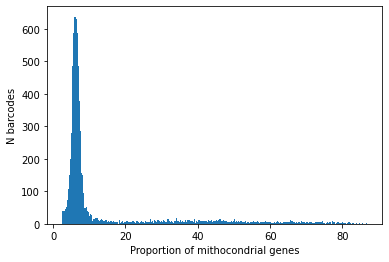

In [53]:
pct_counts_mithocondrial_nodying = np.array([x for x in pct_counts_mithocondrial if x>threshold_pct_counts_mithocondrial_dying_cells])
pct_counts_mithocondrial_nodying_nbins = fd_optimal_bins(pct_counts_mithocondrial_nodying)
plt.figure()
plt.hist(pct_counts_mithocondrial_nodying, bins=pct_counts_mithocondrial_nodying_nbins)
plt.xlabel(labels_pct_counts_mithocondrial['xlabel'])
plt.ylabel(labels_pct_counts_mithocondrial['ylabel'])
plt.show()

<H3>Checking the fat tail looking for doublet using robust linear models analysis of observed transcriptomes</H3>

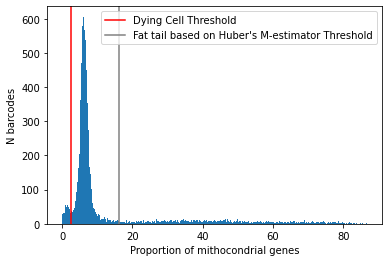

In [54]:
threshold_pct_counts_mithocondrial_doublet_cells, hb_mean_pct_counts_mithocondrial, hb_std_pct_counts_mithocondrial = fat_tail_for_doublets(pct_counts_mithocondrial_nodying, pct_counts_mithocondrial_nodying_nbins, labels_pct_counts_mithocondrial, threshold_pct_counts_mithocondrial_dying_cells, pct_counts_mithocondrial, pct_counts_mithocondrial_nbins)

In [55]:
print(f"Statistics BEFORE fat-tail based on Huber's M-estimator: MEAN {np.mean(pct_counts_mithocondrial_nodying)}, STD {np.std(pct_counts_mithocondrial_nodying)}")
print(f"Statistics AFTER fat-tail based on Huber's M-estimator: MEAN {hb_mean_pct_counts_mithocondrial}, STD {hb_std_pct_counts_mithocondrial}")
print(f"Fat tail based on Huber's M-estimator THRESHOLD: {hb_mean_pct_counts_mithocondrial+3*hb_std_pct_counts_mithocondrial}")

Statistics BEFORE fat-tail based on Huber's M-estimator: MEAN 14.012083053588867, STD 17.130733489990234
Statistics AFTER fat-tail based on Huber's M-estimator: MEAN 7.570497694996672, STD 2.894284751372107
Fat tail based on Huber's M-estimator THRESHOLD: 16.253351949112993


<H2> Dropping dying cells</H2>

After the analysis of the quality control metrics, we have found some thresholds on the metrics that indicates that the cells can be cosidered as died. From that moment, all the work will be done without the dying cells.

<H3> Total cell counts by cell without dying cells</H3>

In [56]:
cellnumber_total_cell_counts_dying_cells = sum(total_cell_counts <= threshold_total_cell_counts_dying_cells)
print(f"{cellnumber_total_cell_counts_dying_cells} of a total of {len(total_cell_counts)} cells are considered as died cells")

2333 of a total of 7677 cells are considered as died cells


In [57]:
ann_object_filter_counts = ann_object.copy()
ann_object_nodying = ann_object.copy()
sc.pp.filter_cells(ann_object_filter_counts, min_counts=threshold_total_cell_counts_dying_cells)
sc.pp.filter_cells(ann_object_nodying, min_counts=threshold_total_cell_counts_dying_cells)
ann_object_filter_counts.shape

(5344, 32285)

<H3>Number of genes represented by cell without dying cells</H3>

In [58]:
cellnumber_n_genes_by_counts = sum(n_genes_by_counts <= threshold_n_genes_by_counts_dying_cells)
print(f"{cellnumber_n_genes_by_counts} of a total of {len(n_genes_by_counts)} cells are considered as died cells")

1893 of a total of 7677 cells are considered as died cells


In [59]:
ann_object_filter_genes = ann_object.copy()
sc.pp.filter_cells(ann_object_filter_genes, min_genes=threshold_n_genes_by_counts_dying_cells)
sc.pp.filter_cells(ann_object_nodying, min_genes=threshold_n_genes_by_counts_dying_cells)
ann_object_filter_genes.shape

(5784, 32285)

<H3>Percentage of mithocondrial genes by cell without dying cells</H3>

In [60]:
cellnumber_pct_counts_mithocondrial = sum(pct_counts_mithocondrial <= threshold_pct_counts_mithocondrial_dying_cells)
print(f"{cellnumber_pct_counts_mithocondrial} of a total of {len(total_cell_counts)} cells are considered as died cells")

372 of a total of 7677 cells are considered as died cells


In [61]:
ann_object_filter_mithocondrialpct = ann_object[ann_object.obs["pct_counts_mithocondrial"] > threshold_pct_counts_mithocondrial_dying_cells].copy()
ann_object_nodying = ann_object_nodying[ann_object_nodying.obs["pct_counts_mithocondrial"] > threshold_pct_counts_mithocondrial_dying_cells].copy()
ann_object_filter_mithocondrialpct.shape

(7305, 32285)

<H2> Dropping doublet cells</H2>

After the analysis of the quality control metrics, we have found some thresholds on the metrics that indicates that the cells can be considered as doubled.

In [62]:
ann_object_filter_counts = ann_object_nodying.copy()
ann_object_nodying_nodoublets = ann_object_nodying.copy()
sc.pp.filter_cells(ann_object_filter_counts, max_counts=threshold_total_cell_counts_doublet_cells)
sc.pp.filter_cells(ann_object_nodying_nodoublets, max_counts=threshold_total_cell_counts_doublet_cells)
ann_object_filter_counts.shape

(5100, 32285)

In [63]:
ann_object_filter_genes = ann_object_nodying.copy()
sc.pp.filter_cells(ann_object_filter_genes, max_genes=threshold_n_genes_by_counts_doublet_cells)
sc.pp.filter_cells(ann_object_nodying_nodoublets, max_genes=threshold_n_genes_by_counts_doublet_cells)
ann_object_filter_genes.shape

(5292, 32285)

In [64]:
ann_object_filter_mithocondrialpct = ann_object_nodying[ann_object_nodying.obs["pct_counts_mithocondrial"] < threshold_pct_counts_mithocondrial_doublet_cells].copy()
ann_object_nodying_nodoublets = ann_object_nodying_nodoublets[ann_object_nodying_nodoublets.obs["pct_counts_mithocondrial"] < threshold_pct_counts_mithocondrial_doublet_cells].copy()
ann_object_filter_mithocondrialpct.shape

(5305, 32285)

In [65]:
ann_object_nodying_nodoublets.shape

(5089, 32285)

<H2>Counts Matrix. Checking the doublets using simulated doublets</H2>

As a next step, we run a doublet detection algorithm. Identifying doublets is crucial as they can lead to misclassifications or distortions in downstream analysis steps.

**Bibliografia**: https://www.researchgate.net/publication/332198015_Scrublet_Computational_Identification_of_Cell_Doublets_in_Single-Cell_Transcriptomic_Data

Fot this, we will use the dataset with the detected died cells dropped.

Using scrublet (https://demultiplexing-doublet-detecting-docs.readthedocs.io/en/latest/Scrublet.html#run-scrublet)

Huriem d'utilitzar això per el expected_doublet_rate? https://uofuhealth.utah.edu/huntsman/shared-resources/gcb/htg/single-cell/genomics-10x i seria 0.039

In [96]:
ann_object_nodying_nodoublets_scrubletdoublet = sc.external.pp.scrublet(ann_object_nodying_nodoublets, expected_doublet_rate=0.039, sim_doublet_ratio = 2, copy=True) #old expected_doublet_rate=ann_object_nodying_nodoublets.shape[0]/1000 * 0.008

/opt/conda/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.21
Detected doublet rate = 2.5%
Estimated detectable doublet fraction = 56.5%
Overall doublet rate:
	Expected   = 3.9%
	Estimated  = 4.4%


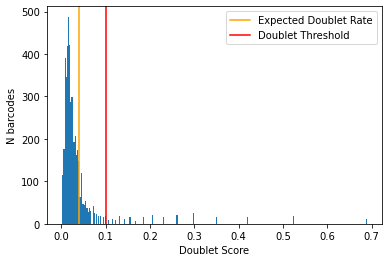

In [99]:
plt.figure()
plt.hist(ann_object_nodying_nodoublets_scrubletdoublet.obs['doublet_score'], bins=fd_optimal_bins(ann_object_nodying_nodoublets_scrubletdoublet.obs['doublet_score']))
plt.xlabel('Doublet Score')
plt.ylabel('N barcodes')
plt.axvline(ann_object_nodying_nodoublets_scrubletdoublet.uns['scrublet']['parameters']['expected_doublet_rate'], color="orange", label="Expected Doublet Rate")
plt.axvline(0.1, color="red", label="Doublet Threshold")
plt.legend()
plt.show()

Visualmente definimos una tasa de doublets del 0.1, porque scrublet la pone en 0.2

In [100]:
ann_object_cleaned = ann_object_nodying_nodoublets_scrubletdoublet[ann_object_nodying_nodoublets_scrubletdoublet.obs['doublet_score'] < 0.1]

we can see that in the simulated doublets, there exists some samples at the right of the threshold. So we can identify a few doublets

<H2> Dropping the doublet cells considered by scrublet </H2>

In [101]:
ann_object_cleaned.shape

(4843, 32285)

<H1> Saving the anndata without dying cells </H1>

In [50]:
ann_object_nodying.write_h5ad('dades/48h/ann_object_withoutdyingcells.h5ad')

<H1> Saving the anndata without dying and doublet cells </H1>

In [51]:
ann_object_nodying_nodoublets.write_h5ad('dades/48h/ann_object_withoutdyingcells_withoutdoubletcells.h5ad')

<H1> Saving the anndata without dying, doublet and scrublet doublet cells</H1>

In [102]:
ann_object_cleaned.write_h5ad('dades/48h/ann_object_withoutdyingcells_withoutdoubletcells_withoutscrubletdoubletcells.h5ad')